<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/%20v2_Final_HyperparamTuning_woImageAug_CM_CR_ROCcurve_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

**XGBoost:** an optimized version of Gradient Boosting / much more evolved version of Random Forest in terms of speed and accuracy

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


## Install Optuna and Version Check

In [2]:
# !pip install --quiet optuna
# import optuna
# optuna.__version__

In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt

# !pip install xgboost
import xgboost as xgb

     |████████████████████████████████| 135 kB 7.1 MB/s 
     |████████████████████████████████| 1.6 MB 49.9 MB/s 


## Enabling and testing the GPU

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Enabling and testing the TPU

## Observe TensorFlow speedup on GPU relative to CPU

In [5]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [6]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
  return idc_image_path, idc_image_label, directory_name

In [7]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [8]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [9]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [10]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [11]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label
103  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
707  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
735  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
3    /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
645  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
613  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
362  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
597  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
324  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
529  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [12]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
753  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
141  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
99   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
117  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
698  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
217  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
796  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
215  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
254  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
621  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
                                                  path    label
125  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
73   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
82   /content/gd

In [13]:
from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [14]:
from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

train_generator = get_img_arrays(df = train_generator)
val_generator = get_img_arrays(df = val_generator)
test_generator = get_img_arrays(df = test_generator)

100%|██████████| 200/200 [00:00<00:00, 36140.66it/s]


In [15]:
# print(train_generator.array_shape.value_counts())
# print(val_generator.array_shape.value_counts())
# print(test_generator.array_shape.value_counts())

In [16]:
# drop these images as they add unnecessary noise to our model
train_weird_imgs = train_generator[train_generator['array_shape'] != 2500]
val_weird_imgs = val_generator[val_generator['array_shape'] != 2500]
test_weird_imgs = test_generator[test_generator['array_shape'] != 2500]


weird_imgs = train_weird_imgs.append(val_weird_imgs)
weird_imgs = weird_imgs.append(test_weird_imgs)
weird_imgs['dataset'] = weird_imgs['path'].str.split('/', expand=True)[7]
weird_imgs.reset_index(drop=True)

train_generator.drop(train_weird_imgs.index,inplace=True)
val_generator.drop(val_weird_imgs.index,inplace=True)
test_generator.drop(test_weird_imgs.index,inplace=True)

# print(len(weird_imgs))
# print(len(train_generator))
# print(len(val_generator))
# print(len(test_generator))
# print(train_generator.columns)
# val_generator.reset_index(drop=True)

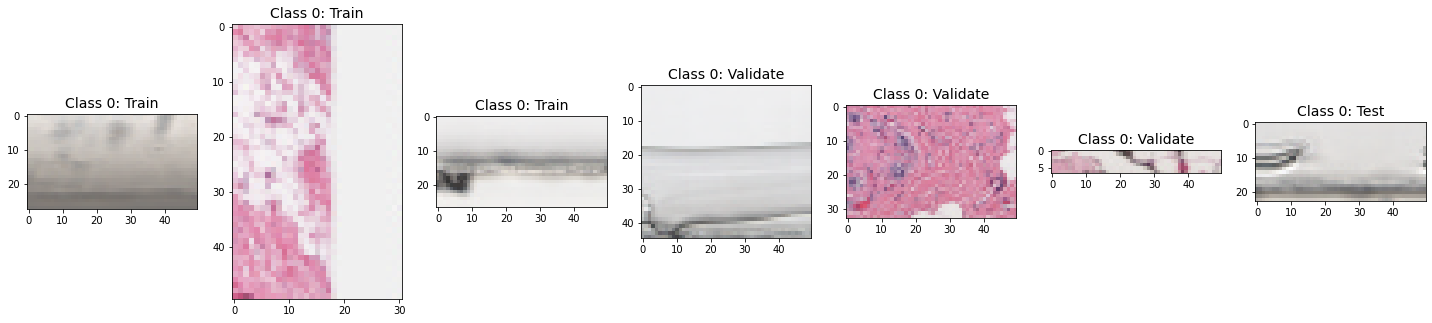

In [17]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass.path[idx])
    # print(image_wo_path)
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass.dataset[idx]
    img = io.imread(subclass.path[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print()
display_images(weird_imgs.reset_index(drop=True))

# Preprocessing data using ImageDataGenerator

In [18]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

def data_generator(target_size = (50,50),
                  with_augmented_images=False,
                  zca_whitening=False,
                  zca_epsilon=1e-06,
                  rotation_range=10,                             
                  width_shift_range=0.0,
                  height_shift_range=0.0,
                  brightness_range=None,
                  shear_range=0.2,                                  
                  zoom_range=0.2,                                
                  channel_shift_range=0.0,                       
                  fill_mode='nearest',                           
                  cval=0.0,
                  horizontal_flip=True,
                  vertical_flip=False,
                  rescale=None):
  
  with_aug_datagen = ImageDataGenerator(
      featurewise_center = True,                     # transforms the images to 0 mean
      featurewise_std_normalization = True,          # divide inputs by std of the dataset
      zca_whitening=zca_whitening,
      zca_epsilon=zca_epsilon,
      rotation_range=rotation_range,                 # randomly rotate image by 10 degrees
      width_shift_range=width_shift_range,
      height_shift_range=height_shift_range,
      brightness_range=brightness_range,
      shear_range=shear_range,                       # distort image along an axis mostly to create or recify the perception angles     
      zoom_range=zoom_range,                         # zomming image: zoom_range > 1 => zoom out, zoom_range < 1 => zoom in
      channel_shift_range=channel_shift_range,                       
      fill_mode=fill_mode,                           # when the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in, 'nearest': simply replace the empty area with the nearest spectral values.
      cval=cval,
      horizontal_flip=horizontal_flip,
      vertical_flip=vertical_flip,
      rescale=rescale)                               # rescale=1./255

  without_aug_datagen = ImageDataGenerator(
      featurewise_center = True,                     
      featurewise_std_normalization = True)
  
# =================================================================
  if with_augmented_images:
    train_data_generator = with_aug_datagen.flow_from_dataframe(
        train_generator,
        directory = None,
        x_col =  'path',
        y_col =  'label',
        weight_col=None,
        target_size=target_size,
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=1234
        # validate_filenames=True
    )
  else:
    train_data_generator = without_aug_datagen.flow_from_dataframe(
        train_generator,
        directory = None,
        x_col =  'path',
        y_col =  'label',
        weight_col=None,
        target_size=target_size,
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=1234
        # validate_filenames=True
    )

  validation_data_generator = without_aug_datagen.flow_from_dataframe(
      val_generator,
      directory = None,
      x_col =  'path',
      y_col =  'label',
      weight_col=None,
      target_size=target_size,
      color_mode="grayscale",
      class_mode="categorical",
      batch_size=32,
      shuffle=True,
      seed=1234
      # validate_filenames=True
  )

  test_data_generator = without_aug_datagen.flow_from_dataframe(
      test_generator,
      directory = None,
      x_col =  'path',
      y_col =  'label',
      weight_col=None,
      target_size=target_size,
      color_mode="grayscale",
      class_mode="categorical",
      batch_size=32,
      shuffle=True,              # Kesha set to shuffle=True but we don't want to shuffle our testing data around, which it does so by default
      seed=1234
      # validate_filenames=True
  )
  return train_data_generator, validation_data_generator, test_data_generator

train_data_generator, validation_data_generator, test_data_generator = data_generator(with_augmented_images=False)

Found 797 validated image filenames belonging to 2 classes.
Found 197 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


# Build CNN Model and Hyperparameter Tuning
- **ReduceLROnPlateau**: A scheduling technique that monitors a particular quantity and decays the learning rate when the quantity is stop improving.
- **ModelCheckpoint**: A sch
- **BatchNormalization**: A feature that we add between the layers of neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer thereby helping stablizing the NN

In [19]:
# img_height = 50
# img_width = 50
# img_channel = 1
# input_shape = (img_height, img_width, img_channel)

In [20]:
from keras.layers import ReLU, LeakyReLU
# https://keras.io/guides/keras_tuner/getting_started/

# 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#  Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish 
def build_cnn(hp, kernel_size = (3,3)): 

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  # kernel_size,
#               strides = strides,
#               pool_size = pool_size,

# Define ranges of hyperparam values 
  hp_img_size = hp.Int('img_size', values=[50, 96, 120], dafault = 50)
  hp_kernel_size = hp.Int('kernel_size', values=[1,3,5], dafault = 3)
  hp_strides = hp.Int('strides', values=[1,2,3], dafault = 1)
  hp_pool_size = hp.Int('pool_size', values=[1,2,3], dafault = 2)
  hp_activation = hp.Choice('activation', values=['tanh', 'relu', 'softmax', 'sigmoid', 'leaky_relu', 'elu', 'gelu','selu','swish'], default='relu')
  hp_optimizer = hp.Choice('optimizer', values=['adadelta', 'adagrad', 'adam', 'rmsprop', 'sgd'], default='adam')
  # hp_kernel_size = hp.Choice('kernel_size', values=[1,2,3])
  hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=256, step=16)
  hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=256, step=16)
  hp_filters_3 = hp.Int('filters_3', min_value=32, max_value=256, step=16)
  hp_dense = hp.Int('dense_units', min_value=32, max_value=512, step=16)
  hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2)
  hp_dropout_1 = hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, default=0.1, step=0.05)
  hp_dropout_2 = hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
  hp_dropout_3 = hp.Float('dropout_rate_3', min_value=0.0, max_value=0.5, default=0.35, step=0.05)
  hp_reduction_type = hp.Choice('reduction_type', values=['global_avg_pooling2d', 'max_pooling2d'])

  # Define the model
  model = tf.keras.Sequential()

  # 1st set of neural network layers (Input layer)
  model.add(Conv2D(filters=hp_filters_1, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation, input_shape = (hp_img_size, hp_img_size, 1)))  
  if hp_reduction_type == 'global_avg_pooling2d':
    model.add(GlobalAveragePooling2D(keepdims=True))
  else:
    model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
  if hp.Boolean('dropout_1'):
    model.add(Dropout(hp_dropout_1))
  
  # 2nd set of neural network layers
  # if hp.Boolean('conv_layer_2'):  
  model.add(Conv2D(filters=hp_filters_2, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation))
  if hp.Boolean('BatchNormalization_1'):
    model.add(BatchNormalization())
  if hp_reduction_type == 'global_avg_pooling2d':
    model.add(GlobalAveragePooling2D(keepdims=True))
  else:
    model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
  if hp.Boolean('dropout_2'):
    model.add(Dropout(hp_dropout_1))

  # 3rd set of neural network layers
  # if hp.Boolean('conv_layer_3'):  
  model.add(Conv2D(filters=hp_filters_3, kernel_size=(hp_kernel_size,hp_kernel_size), padding='same', activation=hp_activation.lower()))
  if hp.Boolean('BatchNormalization_2'):
    model.add(BatchNormalization())
  if hp_reduction_type == 'global_avg_pooling2d':
    model.add(GlobalAveragePooling2D(keepdims=True))
  else:
    model.add(MaxPooling2D(pool_size=(hp_pool_size,hp_pool_size), strides=(hp_strides,hp_strides)))  
  if hp.Boolean('dropout_3'):
    model.add(Dropout(hp_dropout_2))

  # Flatten layer
  model.add(Flatten())

  # Fully connected dense layer
  model.add(Dense(units = hp_dense, activation = hp_activation))
  if hp.Boolean('BatchNormalization_3'):
      model.add(BatchNormalization())
  if hp.Boolean('dropout_4'):
      model.add(Dropout(hp_dropout_3))
  
  # Output layer
  model.add(Dense(units = 2, activation = 'softmax'))        # output layer
  
  # Define the optimizer
  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=hp_learning_rate)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=hp_learning_rate)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
    elif optimizer.lower() == 'adadelta':
        return Adadelta(learning_rate=hp_learning_rate)      # Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-6)
    elif optimizer.lower() == 'adagrad':
        return Adagrad(learning_rate=hp_learning_rate)       # Adagrad(learning_rate=learning_rate, epsilon=1e-6)
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=hp_learning_rate)       # RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-6)

  # Compile the model
  model.compile(loss=CategoricalCrossentropy(), 
                optimizer=selected_optimizer(hp_optimizer), 
                metrics=['accuracy'])
  return model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor = 'val_loss', patience = 3)
# 1) Hyperband
# tuner = kt.Hyperband(build_cnn,                     
#                      objective='accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='hj_dir',
#                      project_name='breast_cancer_classification')
# 2) RandomSearch
tuner = kt.RandomSearch(
          hypermodel=build_cnn,
          objective="val_accuracy",
          max_trials=3,
          executions_per_trial=2,
          overwrite=True,
          directory="hj_dir",
          project_name="breast_cancer_classification")

tuner.search(train_data_generator, 
             epochs=70, 
             callbacks=[stop_early], 
             validation_data=validation_data_generator)

Trial 3 Complete [00h 01m 27s]
val_accuracy: 0.6065990030765533

Best val_accuracy So Far: 0.7208121716976166
Total elapsed time: 00h 03m 19s


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
25/25 [==============================] - ETA: 0s - loss: 1.3973 - accuracy: 0.6951
Epoch 1: val_accuracy improved from -inf to 0.49239, saving model to weights.hdf5
25/25 [==============================] - 6s 208ms/step - loss: 1.3973 - accuracy: 0.6951 - val_loss: 59.6504 - val_accuracy: 0.4924 - lr: 0.0121
Epoch 2/70
25/25 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.7654
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0012111390940845014.

Epoch 2: val_accuracy did not improve from 0.49239
25/25 [==============================] - 3s 114ms/step - loss: 0.5363 - accuracy: 0.7654 - val_loss: 20.5164 - val_accuracy: 0.4924 - lr: 0.0121
Epoch 3/70
25/25 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8118
Epoch 3: val_accuracy improved from 0.49239 to 0.49746, saving model to weights.hdf5
25/25 [==============================] - 5s 207ms/step - loss: 0.4551 - accuracy: 0.8118 - val_loss: 8.7855 - val_accuracy: 0.4975 - 

,test_acc,training_acc,val_acc,num_params
0,0.71,0.83,0.71,"136,694,914"


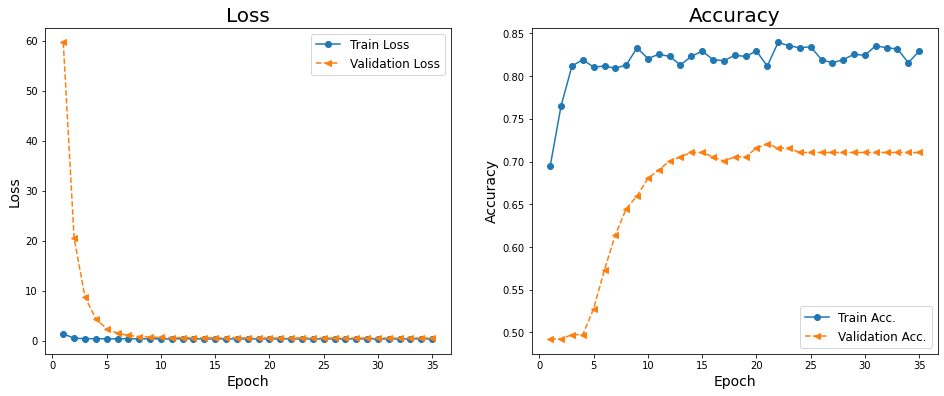

In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

file_path = 'weights.hdf5'    # save the weights and biases
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_data_generator,
                  epochs=70,
                  callbacks=[lr_reduce, checkpoint, stop_early],
                  validation_data = validation_data_generator)
# pd.DataFrame(history.history)

# Plot loss and accuracy of best model on every epoch
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

test_accuracy = round(model.evaluate(test_data_generator, verbose=0,
                          return_dict=True)['accuracy'], 2)
training_accuracy = round(history.history['accuracy'][-1], 2)
val_accuracy = round(history.history['val_accuracy'][-1], 2)
count_params = model.count_params()
model_summary = pd.DataFrame({'test_acc':test_accuracy,
                              'training_acc': training_accuracy,
                              'val_acc': val_accuracy,
                              'num_params':  f'{count_params:,}'}, index=[0]) 

print(model.summary())
model_summary

In [23]:
# Display the hyperparameter values of top 2 models 
tuner.results_summary(2)

Results summary
Results in hj_dir/breast_cancer_classification
Showing 2 best trials
Trial summary
Hyperparameters:
activation: relu
optimizer: sgd
filters_1: 208
filters_2: 240
filters_3: 240
dense_units: 256
learning_rate: 0.012111391157416189
dropout_rate_1: 0.2
dropout_rate_2: 0.2
dropout_rate_3: 0.0
reduction_type: max_pooling2d
dropout_1: False
BatchNormalization_1: True
dropout_2: False
BatchNormalization_2: True
dropout_3: True
BatchNormalization_3: True
dropout_4: False
Score: 0.7208121716976166
Trial summary
Hyperparameters:
activation: selu
optimizer: rmsprop
filters_1: 128
filters_2: 208
filters_3: 224
dense_units: 368
learning_rate: 0.008734924357789484
dropout_rate_1: 0.35000000000000003
dropout_rate_2: 0.25
dropout_rate_3: 0.30000000000000004
reduction_type: max_pooling2d
dropout_1: True
BatchNormalization_1: True
dropout_2: False
BatchNormalization_2: False
dropout_3: False
BatchNormalization_3: False
dropout_4: False
Score: 0.6065990030765533


=============== Classification Report ===============

               precision    recall  f1-score   support

     Non-IDC       0.50      0.46      0.48        99
         IDC       0.50      0.54      0.52       100

    accuracy                           0.50       199
   macro avg       0.50      0.50      0.50       199
weighted avg       0.50      0.50      0.50       199
 



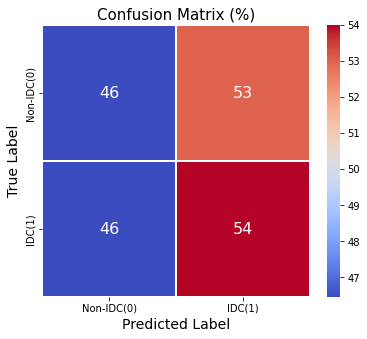

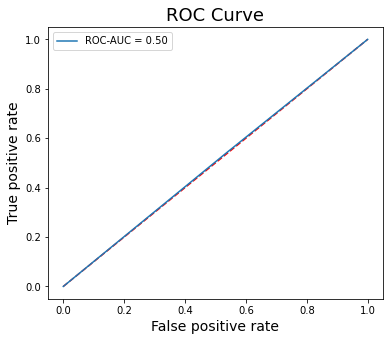

,Model,Accuracy,Precision,Recall,F1_score,ROC-AUC score,Cohen Kappa,Zero-One Loss
0,CNN,0.5,0.5,0.54,0.52,0.5,0.0,0.5


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report

def error_analysis(model_name, model, test_labels, test_data_generator):
  num_of_test_samples = len(test_labels)
  batch_size = 32
  classes = ['Non-IDC(0)','IDC(1)']

  y_true = test_data_generator.classes
  y_pred = model.predict_generator(test_data_generator, num_of_test_samples // batch_size + 1)
  y_pred = np.argmax(y_pred, axis=1)     # return the indicies of the max values along the axis (axis=1: each row)

  # Confusion matrix  
  conf_max = confusion_matrix(y_true, y_pred)
  perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
  df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

  plt.figure(figsize=(6,5))
  sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
  plt.xlabel('Predicted Label', fontsize=14)
  plt.ylabel('True Label', fontsize=14)
  plt.title('Confusion Matrix (%)', fontsize=15)
  
  # Classification report
  print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')
  
  # Cross validation score
  # cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
  # cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
  # print('cv_score = ',cv_score)

  # Precision, recall, and f1_score
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
  accuracy = round(accuracy_score(y_true, y_pred), 2)
  precision = round(precision_score(y_true, y_pred), 2)
  recall = round(recall_score(y_true, y_pred), 2)
  f1score = round((2*precision*recall)/(precision+recall), 2)

  # cohen_kappa score and zero_one loss
  cohen_kappa = round(cohen_kappa_score(y_true, y_pred), 2)
  zo_loss = round(zero_one_loss(y_true, y_pred), 2)

  # Area under the ROC cuver
  roc_log = roc_auc_score(y_true, y_pred)
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
  area_under_curve = round(auc(false_positive_rate, true_positive_rate), 2)

  plt.figure(figsize=(6,5))
  plt.plot([0, 1], [0, 1], 'r--')  
  plt.plot(false_positive_rate, true_positive_rate, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
  plt.xlabel('False positive rate', fontsize=14)
  plt.ylabel('True positive rate', fontsize=14)
  plt.title('ROC Curve', fontsize=18)
  plt.legend(loc='best')
  plt.show()
  # plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
  plt.close()

  model_summary = pd.DataFrame({'Model':model_name,
                                'Accuracy': accuracy,
                                'Precision': precision,
                                'Recall': recall,
                                'F1_score': f1score,
                                'ROC-AUC score': area_under_curve,
                                'Cohen Kappa': cohen_kappa,
                                'Zero-One Loss': zo_loss}, index=[0]) 
  return model_summary
  
error_analysis('CNN', model, test_labels, test_data_generator)

# Run Experiments - Hyperparameter Tuning
- **ReduceLROnPlateau**: A scheduling technique that monitors a particular quantity and decays the learning rate when the quantity is stop improving.
- **ModelCheckpoint**: A sch
- **BatchNormalization**: A feature that we add between the layers of neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer thereby helping stablizing the NN

In [27]:
# def train_and_evaluate(target_size=(50,50),
#                       batch_size = 32,  
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7):
    
#     # preprocess the data 
#     train_data_generator, validation_data_generator, test_data_generator = data_generator(
#                                                                               target_size = target_size,
#                                                                               with_augmented_images = with_augmented_images,
#                                                                               zca_whitening = zca_whitening,
#                                                                               zca_epsilon = zca_epsilon,
#                                                                               rotation_range = rotation_range,                             
#                                                                               width_shift_range = width_shift_range,
#                                                                               height_shift_range = height_shift_range,
#                                                                               brightness_range = brightness_range,
#                                                                               shear_range = shear_range,                                  
#                                                                               zoom_range = zoom_range,                                
#                                                                               channel_shift_range = channel_shift_range,                       
#                                                                               fill_mode = fill_mode,                           
#                                                                               cval = cval,
#                                                                               horizontal_flip = horizontal_flip,
#                                                                               vertical_flip = vertical_flip,
#                                                                               rescale = rescale)
#     # Build model
#     model = build_cnn(kernel_size = kernel_size,
#               strides = strides,
#               pool_size = pool_size,
#               learning_rate = learning_rate,
#               optimizer = optimizer,                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#               activation = activation,               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#               average_over_position = average_over_position,
#               batch_normalization = batch_normalization,
#               dropout_layer = dropout_layer,
#               dropout_rate = dropout_rate, 
#               filters_1 = filters_1,
#               filters_2 = filters_2,
#               filters_3 = filters_3,
#               dense_units = dense_units,
#               conv_layer_2 = conv_layer_2,
#               conv_layer_3 = conv_layer_3)

#     # GridsearchCV
#     # http://man.hubwiz.com/docset/TensorFlow.docset/Contents/Resources/Documents/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier.html

#     # optimizer = ['Tanh', 'Relu', 'softmax', 'sigmoid','Leaky ReLU', 'Parametric ReLU', 'ELU', 'GELU', 'SELU', 'Swish']
#     optimizer = ['Tanh', 'softmax', 'sigmoid','Leaky ReLU', 'Parametric ReLU']
#     activation = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']


#     # Train the model - model.fit
#     print('\nTraining...')
#     lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#     file_path = 'weights.hdf5'    # save the weights and biases
#     checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#     history = grid.fit(train_data_generator)
#                       # epochs=num_epochs,
#                       # callbacks=[lr_reduce, checkpoint],
#                       # validation_data = validation_data_generator)


#     # Plot loss and accuracy on every epoch
#     hist = history.history
#     x_arr = np.arange(len(hist['loss'])) + 1

#     fig = plt.figure(figsize=(16,6))
#     ax = fig.add_subplot(1,2,1)
#     ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#     ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Loss', size=14)
#     ax.set_title('Loss', size=20)

#     ax = fig.add_subplot(1,2,2)
#     ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#     ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Accuracy', size=14)
#     ax.set_title('Accuracy', size=20);
      
#     # Test accuracy - model.evaluate
#     test_accuracy = round(model.evaluate(test_data_generator, verbose=0,
#                              return_dict=True)['accuracy'], 2)
#     training_accuracy = round(history.history['accuracy'][-1], 2)
#     val_accuracy = round(history.history['val_accuracy'][-1], 2)
#     count_params = model.count_params()
    
#     cols = ['num_epochs', 'training_accuracy', 'val_accuracy', 'test_accuracy', 'num_params', 'target_size', 'kernel_size', 'strides', 'pool_size',          
#             'learning_rate', 'optimizer', 'activation', 'average_over_position', 'batch_normalization', 'dropout_layer', 'dropout_rate', 'filters_1', 'filters_2', 'filters_3',
#             'dense_units', 'conv_layer_2', 'conv_layer_3', 'with_augmented_images', 'zca_whitening', 'zca_epsilon', 'rotation_range', 'width_shift_range', 'height_shift_range',
#             'brightness_range', 'shear_range', 'zoom_range', 'channel_shift_range', 'fill_mode', 'cval', 'horizontal_flip', 'vertical_flip', 'rescale']

#     vals = [num_epochs, training_accuracy, val_accuracy, test_accuracy, f'{count_params:,}', target_size, kernel_size, strides, pool_size,          
#             learning_rate, optimizer, activation, average_over_position, batch_normalization, dropout_layer, dropout_rate, filters_1, filters_2, filters_3,
#             dense_units, conv_layer_2, conv_layer_3, with_augmented_images, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range,
#             brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale]
#     experiments = pd.DataFrame({'hyper_params':cols, 'value':vals})
                                        
#     # return model, experiments.reset_index(drop=True)

# model, experiments = train_and_evaluate(target_size=(50,50),  
#                       batch_size = 32,   
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7)
# experiments

In [28]:
# def train_and_evaluate(target_size=(50,50),
#                       batch_size = 32,  
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7):
    
#     # preprocess the data 
#     train_data_generator, validation_data_generator, test_data_generator = data_generator(
#                                                                               target_size = target_size,
#                                                                               with_augmented_images = with_augmented_images,
#                                                                               zca_whitening = zca_whitening,
#                                                                               zca_epsilon = zca_epsilon,
#                                                                               rotation_range = rotation_range,                             
#                                                                               width_shift_range = width_shift_range,
#                                                                               height_shift_range = height_shift_range,
#                                                                               brightness_range = brightness_range,
#                                                                               shear_range = shear_range,                                  
#                                                                               zoom_range = zoom_range,                                
#                                                                               channel_shift_range = channel_shift_range,                       
#                                                                               fill_mode = fill_mode,                           
#                                                                               cval = cval,
#                                                                               horizontal_flip = horizontal_flip,
#                                                                               vertical_flip = vertical_flip,
#                                                                               rescale = rescale)
#     # Build model
#     model = build_cnn(kernel_size = kernel_size,
#               strides = strides,
#               pool_size = pool_size,
#               learning_rate = learning_rate,
#               optimizer = optimizer,                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#               activation = activation,               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#               average_over_position = average_over_position,
#               batch_normalization = batch_normalization,
#               dropout_layer = dropout_layer,
#               dropout_rate = dropout_rate, 
#               filters_1 = filters_1,
#               filters_2 = filters_2,
#               filters_3 = filters_3,
#               dense_units = dense_units,
#               conv_layer_2 = conv_layer_2,
#               conv_layer_3 = conv_layer_3)

#     # GridsearchCV
#     # http://man.hubwiz.com/docset/TensorFlow.docset/Contents/Resources/Documents/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier.html
#     model = KerasClassifier(build_fn=build_cnn,
#                             epochs = num_epochs,
#                             batch_size=batch_size,
#                             verbose=1)
#     # optimizer = ['Tanh', 'softmax', 'sigmoid','Leaky ReLU', 'Parametric ReLU', 'ELU', 'GELU', 'SELU', 'Swish']
#     optimizer = ['Tanh', 'softmax', 'sigmoid','Leaky ReLU', 'Parametric ReLU']
#     activation = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
#     # init_weights = ['uniform', 'normal', 'he_normal']
#     dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

#     param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
#     grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=16, cv=3)
#     # grid_result = grid.fit

#     # Train the model - model.fit
#     print('\nTraining...')
#     lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#     file_path = 'weights.hdf5'    # save the weights and biases
#     checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#     history = grid.fit(train_data_generator)
#                       # epochs=num_epochs,
#                       # callbacks=[lr_reduce, checkpoint],
#                       # validation_data = validation_data_generator)

#     # Summarize results
#     print('Best: %f using %s' % (history.best_score_, history.best_params_))
#     means = history.cv_results_['mean_test_score']
#     std_dev = history.cv_results_['std_test_score']
#     params = history.cv_results_['params']

#     # Plot loss and accuracy on every epoch
#     hist = history.history
#     x_arr = np.arange(len(hist['loss'])) + 1

#     fig = plt.figure(figsize=(16,6))
#     ax = fig.add_subplot(1,2,1)
#     ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#     ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Loss', size=14)
#     ax.set_title('Loss', size=20)

#     ax = fig.add_subplot(1,2,2)
#     ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#     ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Accuracy', size=14)
#     ax.set_title('Accuracy', size=20);
      
#     # Test accuracy - model.evaluate
#     test_accuracy = round(model.evaluate(test_data_generator, verbose=0,
#                              return_dict=True)['accuracy'], 2)
#     training_accuracy = round(history.history['accuracy'][-1], 2)
#     val_accuracy = round(history.history['val_accuracy'][-1], 2)
#     count_params = model.count_params()
    
#     cols = ['num_epochs', 'training_accuracy', 'val_accuracy', 'test_accuracy', 'num_params', 'target_size', 'kernel_size', 'strides', 'pool_size',          
#             'learning_rate', 'optimizer', 'activation', 'average_over_position', 'batch_normalization', 'dropout_layer', 'dropout_rate', 'filters_1', 'filters_2', 'filters_3',
#             'dense_units', 'conv_layer_2', 'conv_layer_3', 'with_augmented_images', 'zca_whitening', 'zca_epsilon', 'rotation_range', 'width_shift_range', 'height_shift_range',
#             'brightness_range', 'shear_range', 'zoom_range', 'channel_shift_range', 'fill_mode', 'cval', 'horizontal_flip', 'vertical_flip', 'rescale']

#     vals = [num_epochs, training_accuracy, val_accuracy, test_accuracy, f'{count_params:,}', target_size, kernel_size, strides, pool_size,          
#             learning_rate, optimizer, activation, average_over_position, batch_normalization, dropout_layer, dropout_rate, filters_1, filters_2, filters_3,
#             dense_units, conv_layer_2, conv_layer_3, with_augmented_images, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range,
#             brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale]
#     experiments = pd.DataFrame({'hyper_params':cols, 'value':vals})
                                        
#     # return model, experiments.reset_index(drop=True)

# model, experiments = train_and_evaluate(target_size=(50,50),  
#                       batch_size = 32,   
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7)
# experiments

In [29]:
# def train_and_evaluate(target_size=(50,50),    
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7):
    
#     # preprocess the data 
#     train_data_generator, validation_data_generator, test_data_generator = data_generator(
#                                                                               target_size = target_size,
#                                                                               with_augmented_images = with_augmented_images,
#                                                                               zca_whitening = zca_whitening,
#                                                                               zca_epsilon = zca_epsilon,
#                                                                               rotation_range = rotation_range,                             
#                                                                               width_shift_range = width_shift_range,
#                                                                               height_shift_range = height_shift_range,
#                                                                               brightness_range = brightness_range,
#                                                                               shear_range = shear_range,                                  
#                                                                               zoom_range = zoom_range,                                
#                                                                               channel_shift_range = channel_shift_range,                       
#                                                                               fill_mode = fill_mode,                           
#                                                                               cval = cval,
#                                                                               horizontal_flip = horizontal_flip,
#                                                                               vertical_flip = vertical_flip,
#                                                                               rescale = rescale)
#     # Build model
#     model = build_cnn(kernel_size = kernel_size,
#               strides = strides,
#               pool_size = pool_size,
#               learning_rate = learning_rate,
#               optimizer = optimizer,                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#               activation = activation,               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#               average_over_position = average_over_position,
#               batch_normalization = batch_normalization,
#               dropout_layer = dropout_layer,
#               dropout_rate = dropout_rate, 
#               filters_1 = filters_1,
#               filters_2 = filters_2,
#               filters_3 = filters_3,
#               dense_units = dense_units,
#               conv_layer_2 = conv_layer_2,
#               conv_layer_3 = conv_layer_3)

    
#     # Train the model - model.fit
#     print('\nTraining...')
#     lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#     file_path = 'weights.hdf5'    # save the weights and biases
#     checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#     history = model.fit(train_data_generator,
#                       epochs=num_epochs,
#                       callbacks=[lr_reduce, checkpoint],
#                       validation_data = validation_data_generator)

    
#     # Plot loss and accuracy on every epoch
#     hist = history.history
#     x_arr = np.arange(len(hist['loss'])) + 1

#     fig = plt.figure(figsize=(16,6))
#     ax = fig.add_subplot(1,2,1)
#     ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#     ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Loss', size=14)
#     ax.set_title('Loss', size=20)

#     ax = fig.add_subplot(1,2,2)
#     ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#     ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#     ax.legend(fontsize=12)
#     ax.set_xlabel('Epoch', size=14)
#     ax.set_ylabel('Accuracy', size=14)
#     ax.set_title('Accuracy', size=20);
      
#     # Test accuracy - model.evaluate
#     test_accuracy = round(model.evaluate(test_data_generator, verbose=0,
#                              return_dict=True)['accuracy'], 2)
#     training_accuracy = round(history.history['accuracy'][-1], 2)
#     val_accuracy = round(history.history['val_accuracy'][-1], 2)
#     count_params = model.count_params()
    
#     cols = ['num_epochs', 'training_accuracy', 'val_accuracy', 'test_accuracy', 'num_params', 'target_size', 'kernel_size', 'strides', 'pool_size',          
#             'learning_rate', 'optimizer', 'activation', 'average_over_position', 'batch_normalization', 'dropout_layer', 'dropout_rate', 'filters_1', 'filters_2', 'filters_3',
#             'dense_units', 'conv_layer_2', 'conv_layer_3', 'with_augmented_images', 'zca_whitening', 'zca_epsilon', 'rotation_range', 'width_shift_range', 'height_shift_range',
#             'brightness_range', 'shear_range', 'zoom_range', 'channel_shift_range', 'fill_mode', 'cval', 'horizontal_flip', 'vertical_flip', 'rescale']

#     vals = [num_epochs, training_accuracy, val_accuracy, test_accuracy, f'{count_params:,}', target_size, kernel_size, strides, pool_size,          
#             learning_rate, optimizer, activation, average_over_position, batch_normalization, dropout_layer, dropout_rate, filters_1, filters_2, filters_3,
#             dense_units, conv_layer_2, conv_layer_3, with_augmented_images, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range,
#             brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale]
#     experiments = pd.DataFrame({'hyper_params':cols, 'value':vals})
                                        
#     return model, experiments.reset_index(drop=True)

# model, experiments = train_and_evaluate(target_size=(50,50),    
#                       with_augmented_images=False,
#                       zca_whitening=False,
#                       zca_epsilon=1e-06,
#                       rotation_range=10,                             
#                       width_shift_range=0.0,
#                       height_shift_range=0.0,
#                       brightness_range=None,
#                       shear_range=0.2,                                  
#                       zoom_range=0.2,                                
#                       channel_shift_range=0.0,                       
#                       fill_mode='nearest',                           
#                       cval=0.0,
#                       horizontal_flip=True,
#                       vertical_flip=False,
#                       rescale=None,
#                       kernel_size = (3,3),
#                       strides = (1,1),
#                       pool_size = (2,2),
#                       learning_rate = 0.001,
#                       optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#                       activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#                       average_over_position=False,
#                       batch_normalization=True,
#                       dropout_layer=True,
#                       dropout_rate=0.5, 
#                       filters_1=32,
#                       filters_2=64,
#                       filters_3=128,
#                       dense_units=256,
#                       conv_layer_2=True,
#                       conv_layer_3=True,
#                       num_epochs=7)
# experiments

- **Cohen Kappa:**</font> a score that expresses the level of agreement between Observed Accuracy with an Expected Accuracy (random chance). value <= 0 means *no agreement* and close to 1 means almsot perfect agreement (the higher ck value, the higher agreement between the OA and EA. 
- **Zero-One Loss:**</font> return the fraction of misclassifications (float), else it returns the number of misclassifications (int). The best performance is 0.

In [30]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report

# def error_analysis(model_name, model, test_labels, test_data_generator):
#   num_of_test_samples = len(test_labels)
#   batch_size = 32
#   classes = ['Non-IDC(0)','IDC(1)']

#   y_true = test_data_generator.classes
#   y_pred = model.predict_generator(test_data_generator, num_of_test_samples // batch_size + 1)
#   y_pred = np.argmax(y_pred, axis=1)     # return the indicies of the max values along the axis (axis=1: each row)

#   # Confusion matrix  
#   conf_max = confusion_matrix(y_true, y_pred)
#   perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
#   df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

#   plt.figure(figsize=(6,5))
#   sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
#   plt.xlabel('Predicted Label', fontsize=14)
#   plt.ylabel('True Label', fontsize=14)
#   plt.title('Confusion Matrix (%)', fontsize=15)
  
#   # Classification report
#   print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')
  
#   # Cross validation score
#   # cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
#   # cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
#   # print('cv_score = ',cv_score)

#   # Precision, recall, and f1_score
#   tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
#   accuracy = round(accuracy_score(y_true, y_pred), 2)
#   precision = round(precision_score(y_true, y_pred), 2)
#   recall = round(recall_score(y_true, y_pred), 2)
#   f1score = round((2*precision*recall)/(precision+recall), 2)

#   # cohen_kappa score and zero_one loss
#   cohen_kappa = round(cohen_kappa_score(y_true, y_pred), 2)
#   zo_loss = round(zero_one_loss(y_true, y_pred), 2)

#   # Area under the ROC cuver
#   roc_log = roc_auc_score(y_true, y_pred)
#   false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
#   area_under_curve = round(auc(false_positive_rate, true_positive_rate), 2)

#   plt.figure(figsize=(6,5))
#   plt.plot([0, 1], [0, 1], 'r--')  
#   plt.plot(false_positive_rate, true_positive_rate, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
#   plt.xlabel('False positive rate', fontsize=14)
#   plt.ylabel('True positive rate', fontsize=14)
#   plt.title('ROC Curve', fontsize=18)
#   plt.legend(loc='best')
#   plt.show()
#   # plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
#   plt.close()

#   model_summary = pd.DataFrame({'Model':model_name,
#                                 'Accuracy': accuracy,
#                                 'Precision': precision,
#                                 'Recall': recall,
#                                 'F1_score': f1score,
#                                 'ROC-AUC score': area_under_curve,
#                                 'Cohen Kappa': cohen_kappa,
#                                 'Zero-One Loss': zo_loss}, index=[0]) 
#   return model_summary
  
# error_analysis('CNN', model, test_labels, test_data_generator)

# Transfer Learning
- **ResNet152V2**
- **VGG16**
- **VGG19**

In [31]:
# from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

# # https://keras.io/api/applications/
# tf.keras.backend.clear_session()
# tf.random.set_seed(1234)

# input_shape = (50,50,3)
# vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
# vgg19_base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
# resnet_base_model = ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')

# # vgg16_base_model.summary()
# # vgg19_base_model.summary()
# # resnet_base_model.summary()

In [32]:
# def build_cnn_tl(model_tl):
#   return tf.keras.Sequential([
#                            model_tl,                           
#                            Flatten(),

#                            Dense(units = 1024, activation = 'relu'),
#                            BatchNormalization(),                           
#                            Dropout(rate=0.5),

#                            Dense(units = 128, activation = 'relu'),
#                            BatchNormalization(),                           
#                            Dropout(rate=0.4),

#                            Dense(units = 2, activation = 'softmax')
# ])  

In [33]:
# # freeze initial layer of the network, making only the fully connected layer we added trainable
# vgg16_base_model.trainable = False
# vgg19_base_model.trainable = False
# resnet_base_model.trainable = False

# # run each model
# model_vgg16 = build_cnn_tl(vgg16_base_model)
# model_vgg19 = build_cnn_tl(vgg19_base_model)
# model_resnet = build_cnn_tl(resnet_base_model)

In [34]:
# def model_compile_tl(model_tl, optimizer='Adam', learning_rate = 0.001):
#   # select optimizer
#   def selected_optimizer(optimizer):
#       if optimizer.lower() == 'sgd':
#           return SGD(learning_rate=learning_rate)
#       if optimizer.lower() == 'adam':
#           return Adam(learning_rate=learning_rate)

#   model_tl.compile(optimizer=selected_optimizer(optimizer), 
#                       loss=keras.losses.categorical_crossentropy, 
#                       metrics=['accuracy'])
#   model_tl.summary()
#   return model_tl

# model_vgg16 = model_compile_tl(model_vgg16, optimizer='Adam', learning_rate = 0.001)
# # model_vgg19 = model_compile_tl(model_vgg19, optimizer='Adam', learning_rate = 0.001)
# model_resnet = model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)

In [35]:
# def model_fit_tl(model_tl, train_data_generator, validation_data_generator, epochs=10):
#   lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#   file_path = 'weights.hdf5'    # save the weights and biases
#   checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#   history = model_tl.fit(np.repeat(train_data_generator, 3, -1),
#                   epochs = epochs,
#                   callbacks = [lr_reduce, checkpoint],
#                   validation_data = np.repeat(validation_data_generator, 3, -1))
#   return history
# history_tl = model_fit_tl(model_vgg16, train_data_generator, validation_data_generator, 10)

In [36]:
# def model_fit_and_plot_loss_acc(model_tl):
#   history = model_fit_tl(model_tl, train_data_generator, validation_data_generator, 10)
#   hist = history.history
#   x_arr = np.arange(len(hist['loss'])) + 1

#   fig = plt.figure(figsize=(16,6))
#   ax = fig.add_subplot(1,2,1)
#   ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#   ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Loss', size=14)
#   ax.set_title('Loss', size=20)

#   ax = fig.add_subplot(1,2,2)
#   ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#   ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Accuracy', size=14)
#   ax.set_title('Accuracy', size=20);

# # model_fit_and_plot_loss_acc(model_vgg16)
# # model_fit_and_plot_loss_acc(model_vgg19)
# model_fit_and_plot_loss_acc(model_vgg16)

In [37]:
# model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)
# model_fit_tl(model_resnet, train_data_generator, validation_data_generator, epochs=7)
# plot_loss_acc(history_tl)
# model_evaluate(model_resnet, train_data_generator, test_data_generator)
# error_analysis(test_labels, test_data_generator)

In [38]:
# plot_loss_acc(history_tl)

In [39]:
# model_evaluate(model_resnet, train_data_generator, test_data_generator)

In [40]:
# error_analysis(test_labels, test_data_generator)